# OCR using CNN

## Importing required libraries

In [1]:
import tensorflow as tf
print("Tensorflow imported")
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os

Tensorflow imported


Setting GPU memory growth limit to prevent Out of memory issues

In [2]:
gpus = tf.config.experimental.list_physical_devices("GPU")
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu,True)
gpus

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## Load Dataset
Load dataset from dataset folder in grayscale format with image size 40x60 px

In [4]:
data = tf.keras.utils.image_dataset_from_directory('dataset',image_size=(40,60),color_mode="grayscale")

Found 210227 files belonging to 62 classes.


Image data iterator used to access images stored in batches

In [5]:
data_iter = data.as_numpy_iterator()
data_iter

Accessing next batch of images

In [6]:
batch = data_iter.next()

General lookup of how each batch variable looks and its shape <br>
Also the class names are printed

In [7]:
print(len(batch),batch[1],batch[0].shape)
print(data.class_names)
class_names = data.class_names

2 [49 53 16 38  4 58 27 24 40  8 11  0  3 44 54 52  8 30 24  7  2 16 56 10
 27 61  3 19  3  0 27 20] (32, 40, 60, 1)
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A_U', 'B_U', 'C_U', 'D_U', 'E_U', 'F_U', 'G_U', 'H_U', 'I_U', 'J_U', 'K_U', 'L_U', 'M_U', 'N_U', 'O_U', 'P_U', 'Q_U', 'R_U', 'S_U', 'T_U', 'U_U', 'V_U', 'W_U', 'X_U', 'Y_U', 'Z_U', 'a_L', 'b_L', 'c_L', 'd_L', 'e_L', 'f_L', 'g_L', 'h_L', 'i_L', 'j_L', 'k_L', 'l_L', 'm_L', 'n_L', 'o_L', 'p_L', 'q_L', 'r_L', 's_L', 't_L', 'u_L', 'v_L', 'w_L', 'x_L', 'y_L', 'z_L']


### Plotting data to check if the loading was right

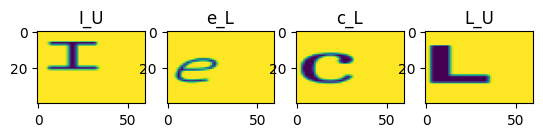

In [8]:
fig, ax = plt.subplots(1,4)
'''
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].set_title(class_names[batch[1][idx]])
'''

# Alternate way to view plots from tensorflow docs
for images, labels in data.take(1):
    for i in range(4):
        ax[i].imshow(images[i].numpy().astype(int))
        ax[i].set_title(class_names[labels[i]])
#print(img.shape)
#plt.imshow(img)

## Scale data
Scaling the image data from 0 to 1 so that tensorflow can run models in it properly

In [9]:
data = data.map(lambda x,y:(x/255,y))

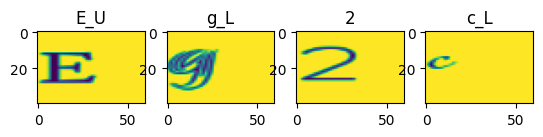

In [10]:
fig, ax = plt.subplots(1,4)
for images, labels in data.take(1):
    for i in range(4):
        ax[i].imshow(images[i].numpy())
        ax[i].set_title(class_names[labels[i]])
plt.show()

In [11]:
data_iter_val = data.as_numpy_iterator()

In [12]:
batch = data_iter_val.next()
print(batch[1])
batch[0].shape

[42 12 46 30 11  8 17  7  2 60  9 18 17 33 57 38 12 61  1 52 59 32 42 50
 38 27 19 40 33 33 45 32]


(32, 40, 60, 1)

## Splitting data
Train dataset size = 70% <br>
Testing dataset size = 20% <br>
Validation dataset size = 10%

In [13]:
train_size = int(len(data)*0.7)
val_size = int(len(data)*0.2)
test_size = int(len(data)*0.1)
print(f"Training dataset size: {train_size}\nVal. dataset size: {test_size}\nTest dataset size: {val_size}\nTotal: {len(data)}")
print(f"Total size after splitting: {train_size+test_size+val_size}")
print(f"Was the split right: {train_size+test_size+val_size==len(data)}")

Training dataset size: 4599
Val. dataset size: 657
Test dataset size: 1314
Total: 6570
Total size after splitting: 6570
Was the split right: True


In [14]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

## Training the Model!

In [17]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout

In [18]:
tf.random.set_seed(42)
# Create our model (a clone of model_8, except to be multi-class)
model_baseline= Sequential([
  Conv2D(16, 3, activation='relu', input_shape=(40,60,1)),
  
  Conv2D(32, 3, activation='relu'),
  MaxPool2D(pool_size=2, # pool_size can also be (2, 2)
            padding="valid"), # padding can also be 'same'
  
  Conv2D(16, 3, activation='relu'),
  
  Conv2D(32, 3, activation='relu'),
  MaxPool2D(pool_size=2, # pool_size can also be (2, 2)
            padding="valid"), # padding can also be 'same'

  Conv2D(16, 3, activation='relu'),
  
  Conv2D(32, 3, activation='relu'),
  MaxPool2D(pool_size=2, # pool_size can also be (2, 2)
            padding="valid"), # padding can also be 'same'
  
  Flatten(),
  Dense(62, activation='softmax') # changed to have 10 neurons (same as number of classes) and 'softmax' activation
])

In [19]:
model_baseline.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 38, 58, 16)        160       
                                                                 
 conv2d_1 (Conv2D)           (None, 36, 56, 32)        4640      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 18, 28, 32)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 26, 16)        4624      
                                                                 
 conv2d_3 (Conv2D)           (None, 14, 24, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 12, 32)        0         
 2D)                                                    

In [20]:
# Compile the model
model_baseline.compile(loss="sparse_categorical_crossentropy", # changed to categorical_crossentropy
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [21]:
#Fit the model
history_baseline = model_baseline.fit(train,
                            epochs=2,
                            steps_per_epoch=len(train),
                            validation_data=val)
                            #validation_steps=len(val))

Epoch 1/2
4599/4599 [==============================] - 156s 33ms/step - loss: 1.0439 - accuracy: 0.7434 - val_loss: 0.6009 - val_accuracy: 0.8440
Epoch 2/2
4599/4599 [==============================] - 158s 34ms/step - loss: 0.5478 - accuracy: 0.8558 - val_loss: 0.5064 - val_accuracy: 0.8641


In [22]:
model_baseline.save("second_try.h5")

### Loss and Accuracy

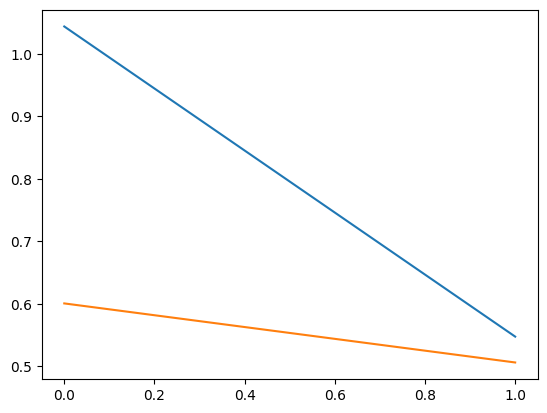

In [26]:
plt.plot(history_baseline.history["loss"])
plt.plot(history_baseline.history["val_loss"])

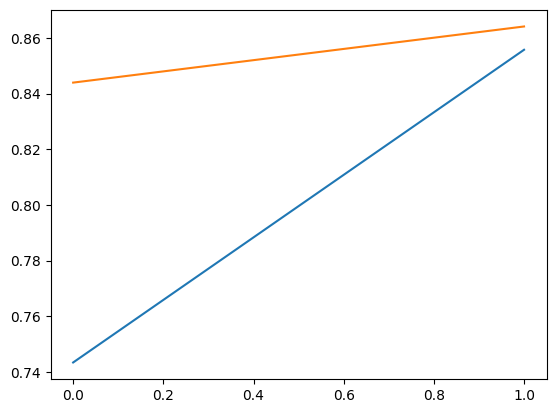

In [27]:
plt.plot(history_baseline.history["accuracy"])
plt.plot(history_baseline.history["val_accuracy"])

### Evaluate

In [28]:
from tensorflow.keras.metrics import Precision, Recall, Accuracy

In [29]:
pre = Precision()
re = Recall()
acc = Accuracy()

In [31]:
# for batch in test.as_numpy_iterator(): 
#     X, y = batch
#     yhat = model_baseline.predict(X)
#     pre.update_state(y, yhat)
#     re.update_state(y, yhat)
#     acc.update_state(y, yhat)

In [32]:
print(pre.result(),re.result(),acc.result())

tf.Tensor(0.0, shape=(), dtype=float32) tf.Tensor(0.0, shape=(), dtype=float32) tf.Tensor(0.0, shape=(), dtype=float32)


### Test

In [195]:
from tensorflow.keras.models import load_model

In [196]:
loaded_model = load_model("first_try.h5")

In [197]:
import random

In [198]:
def load_random():
    ranges = [*range(0,3300,1)]
    values = random.choices(ranges,k=62)
    images = list()
    for i in range(len(values)):
        if i<10:
            img = cv2.imread(f"./dataset/{i}/{values[i]}.png")
        else:
            img = cv2.imread(f"./dataset/{class_names[i]}/{class_names[i]}_{values[i]}.png")
        if img is not None:
            images.append(img)
        else:
            if i<10:
                img = cv2.imread(f"./dataset/{i}/1.png")
            else:
                img = cv2.imread(f"./dataset/{class_names[i]}/{class_names[i]}_1.png")
#             while True:
#                 val = values[i]
#                 if i<10:
#                     img = cv2.imread(f"./dataset/{i}/{val+1}.png")
#                 else:
#                     print("whoa")
#                     img = cv2.imread(f"./dataset/{class_names[i]}/{class_names[i]}_{val+1}.png")
#                 if img is not None:
#                     break
#                 else:
#                     val +=1
    return images
        
    
def plot_those_imgs(images,**kwargs):
    fig, ax = plt.subplots(8,8,figsize=(16,16))
    fig.tight_layout()
    for i in range(len(images)):
        ax[i//8,i%8].imshow(images[i])
        if len(kwargs)==0:
            ax[i//8,i%8].title.set_text(f"{class_names[i]}")
        else:
            ax[i//8,i%8].title.set_text(f"{class_names[i]} - {kwargs['acc'][i]}")
    plt.show()

61
58


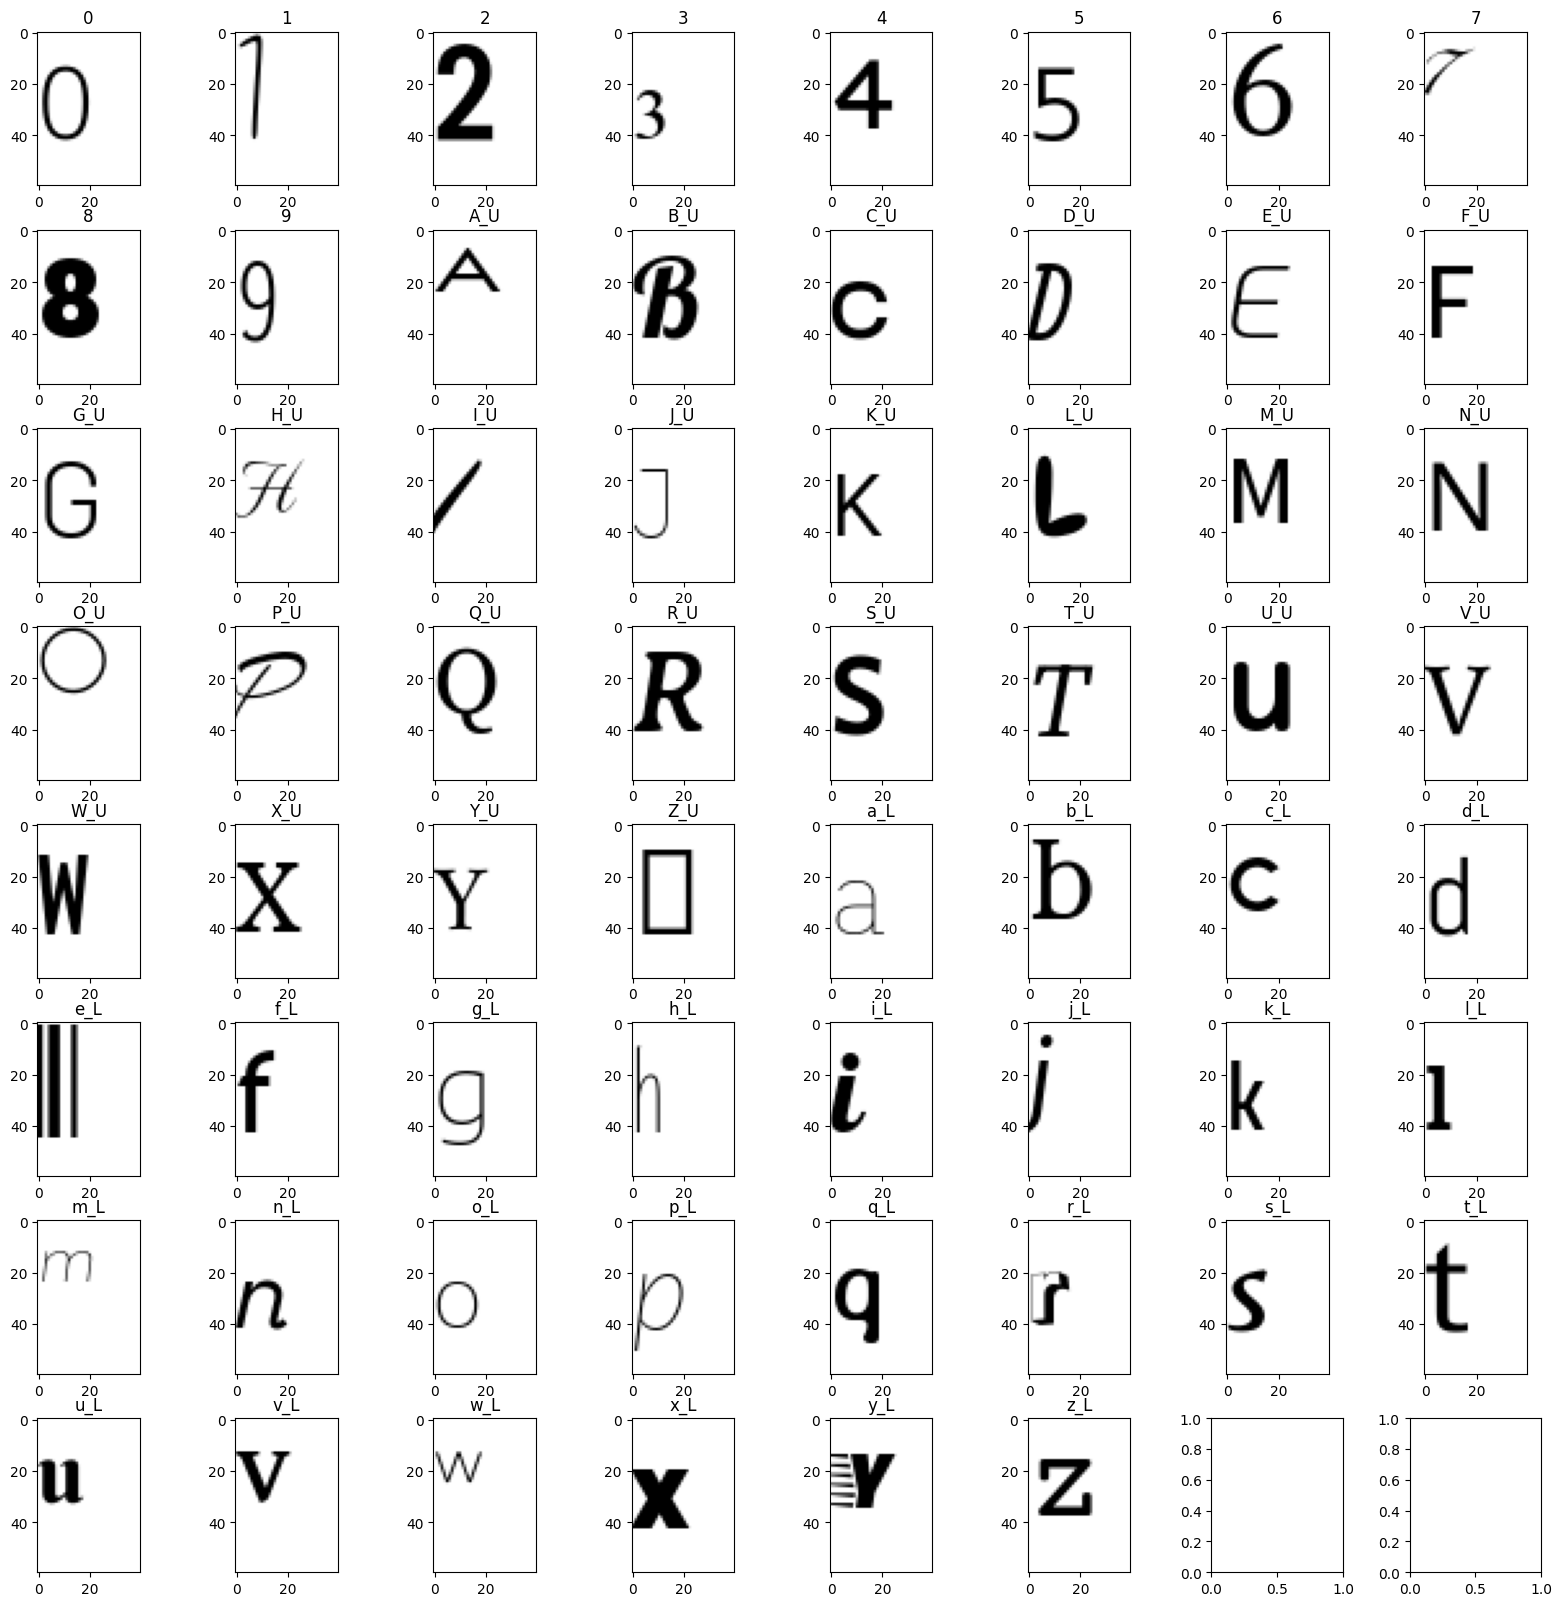

In [203]:
while True:
    images = load_random()
    if len(images)==62:
        break
    print(len(images))

plot_those_imgs(images)

plt.close()

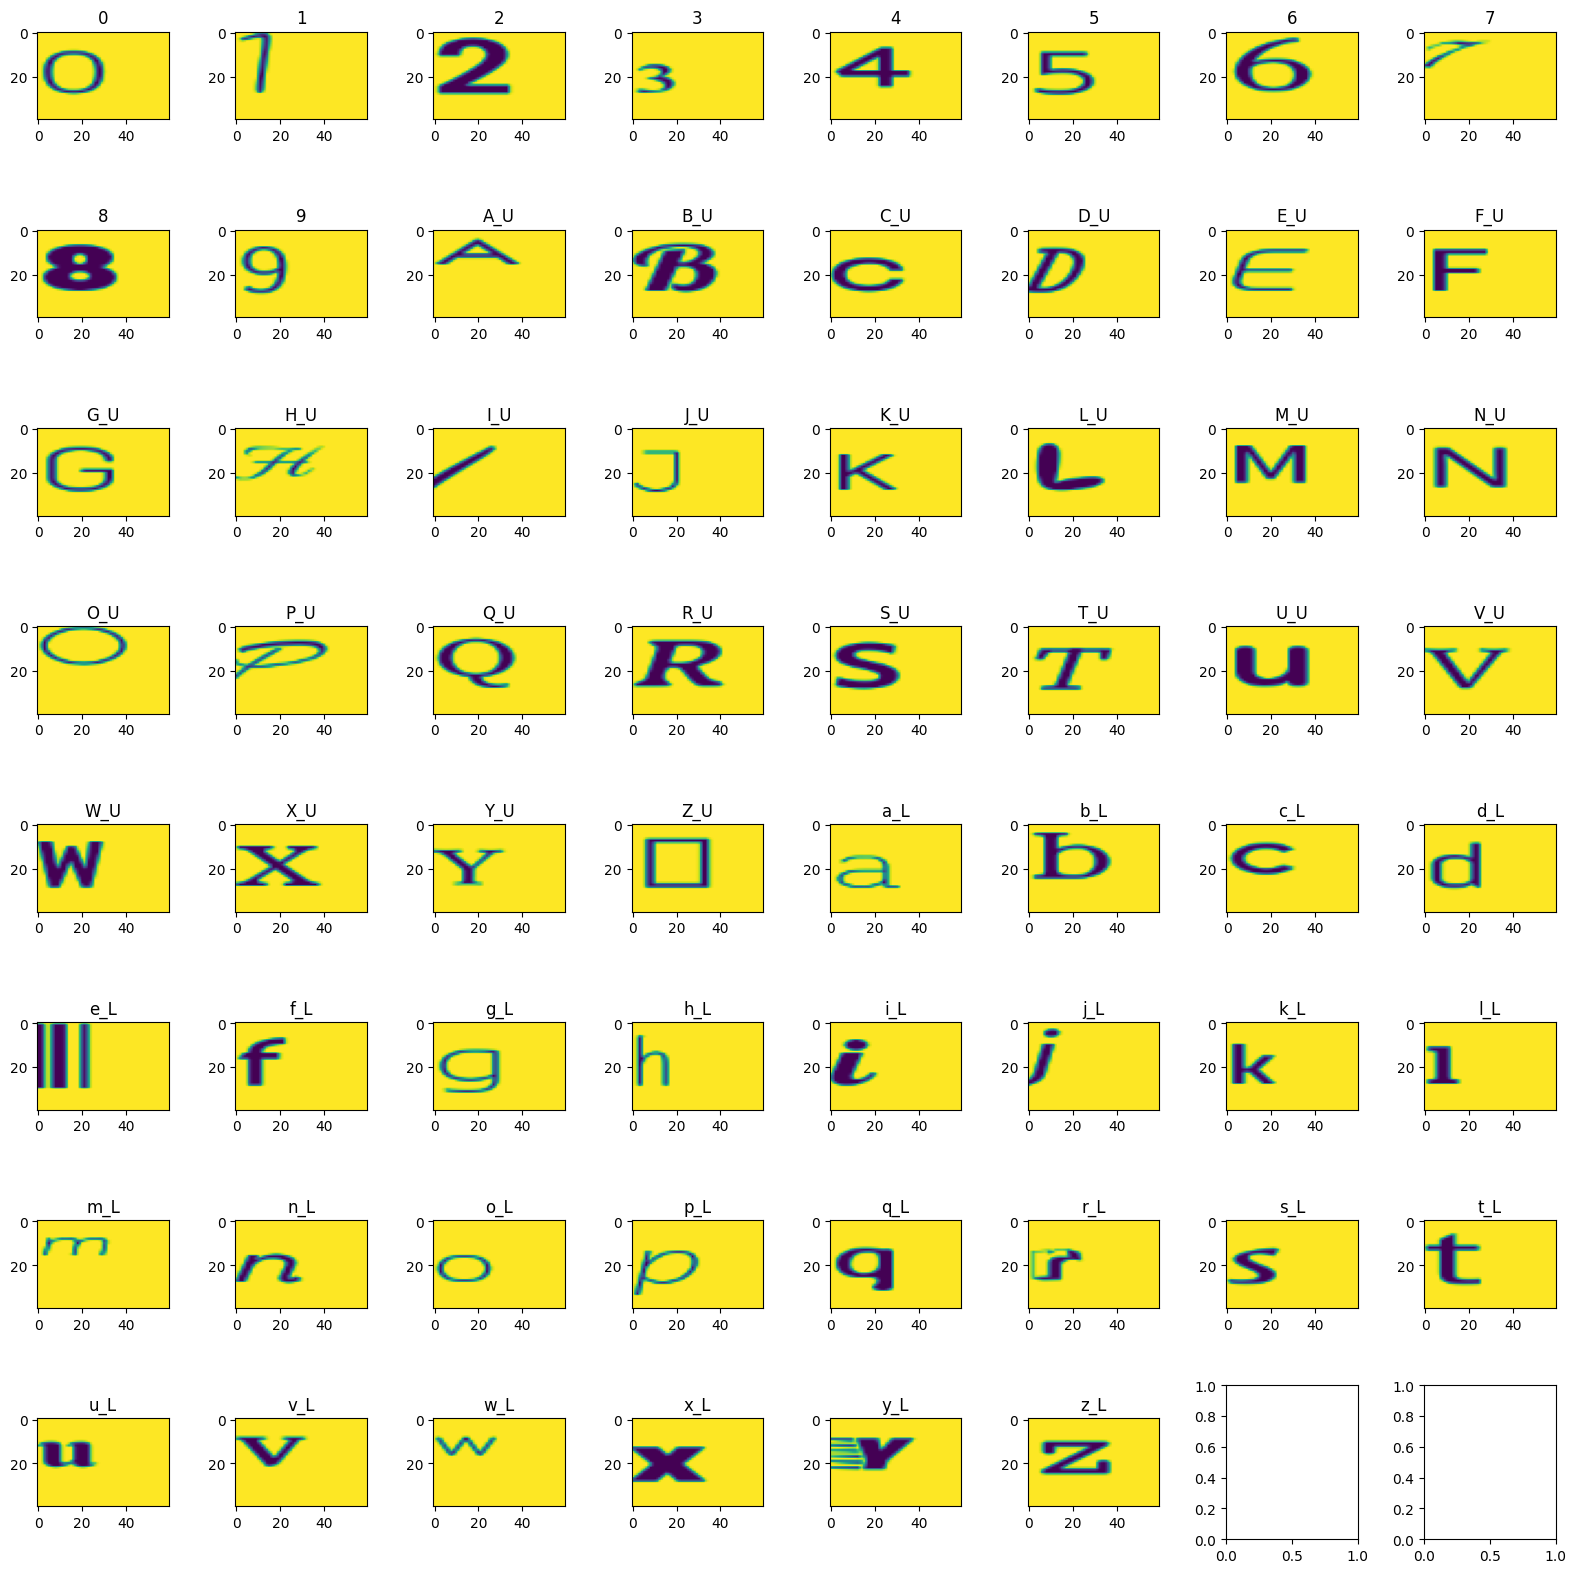

In [204]:
resize = tf.image.resize(tf.image.rgb_to_grayscale(images),(40,60))
plot_those_imgs(resize)

In [205]:
yhat = loaded_model.predict(*np.expand_dims(resize/255, 0))
yhat

array([[8.61786544e-01, 9.51606722e-08, 1.04917106e-07, ...,
        1.36155254e-10, 3.05994746e-07, 1.35941502e-09],
       [1.54991914e-03, 5.13736069e-01, 3.60360980e-04, ...,
        1.37266441e-04, 4.92232211e-04, 1.70224754e-04],
       [6.40870157e-09, 6.33980903e-07, 8.99647772e-01, ...,
        5.49428725e-09, 2.91885370e-11, 1.42819365e-03],
       ...,
       [1.44724163e-10, 4.51727743e-07, 5.68210339e-07, ...,
        8.94240320e-01, 2.98061168e-05, 1.26594881e-04],
       [2.09739278e-06, 1.44373756e-04, 2.37774088e-06, ...,
        6.43885069e-05, 4.86676954e-03, 6.95368598e-08],
       [1.76312128e-07, 6.75451156e-06, 4.20153216e-02, ...,
        1.43534940e-04, 1.23517148e-05, 2.75667995e-01]], dtype=float32)

['0.86 - 0', '0.51 - 1', '0.9 - 2', '0.52 - 3', '1.0 - 4', '1.0 - 5', '1.0 - 6', '0.48 - r_L', '0.99 - 8', '0.94 - 9', '0.86 - A_U', '0.98 - B_U', '0.92 - c_L', '0.96 - D_U', '0.96 - E_U', '0.99 - F_U', '0.98 - G_U', '0.67 - R_U', '0.44 - v_L', '0.81 - J_U', '0.98 - K_U', '1.0 - L_U', '1.0 - M_U', '1.0 - N_U', '0.4 - O_U', '0.89 - P_U', '1.0 - Q_U', '1.0 - R_U', '0.99 - S_U', '1.0 - T_U', '0.89 - u_L', '0.99 - V_U', '0.45 - N_U', '1.0 - X_U', '0.99 - Y_U', '0.15 - E_U', '0.98 - a_L', '0.95 - b_L', '0.98 - c_L', '1.0 - d_L', '0.4 - N_U', '1.0 - f_L', '0.97 - g_L', '0.79 - h_L', '1.0 - i_L', '0.99 - j_L', '0.98 - k_L', '0.67 - l_L', '0.83 - m_L', '0.99 - n_L', '0.94 - o_L', '0.83 - p_L', '0.95 - q_L', '0.5 - r_L', '1.0 - s_L', '0.99 - t_L', '0.88 - u_L', '0.92 - v_L', '1.0 - w_L', '0.89 - x_L', '0.88 - Y_U', '0.68 - Z_U']


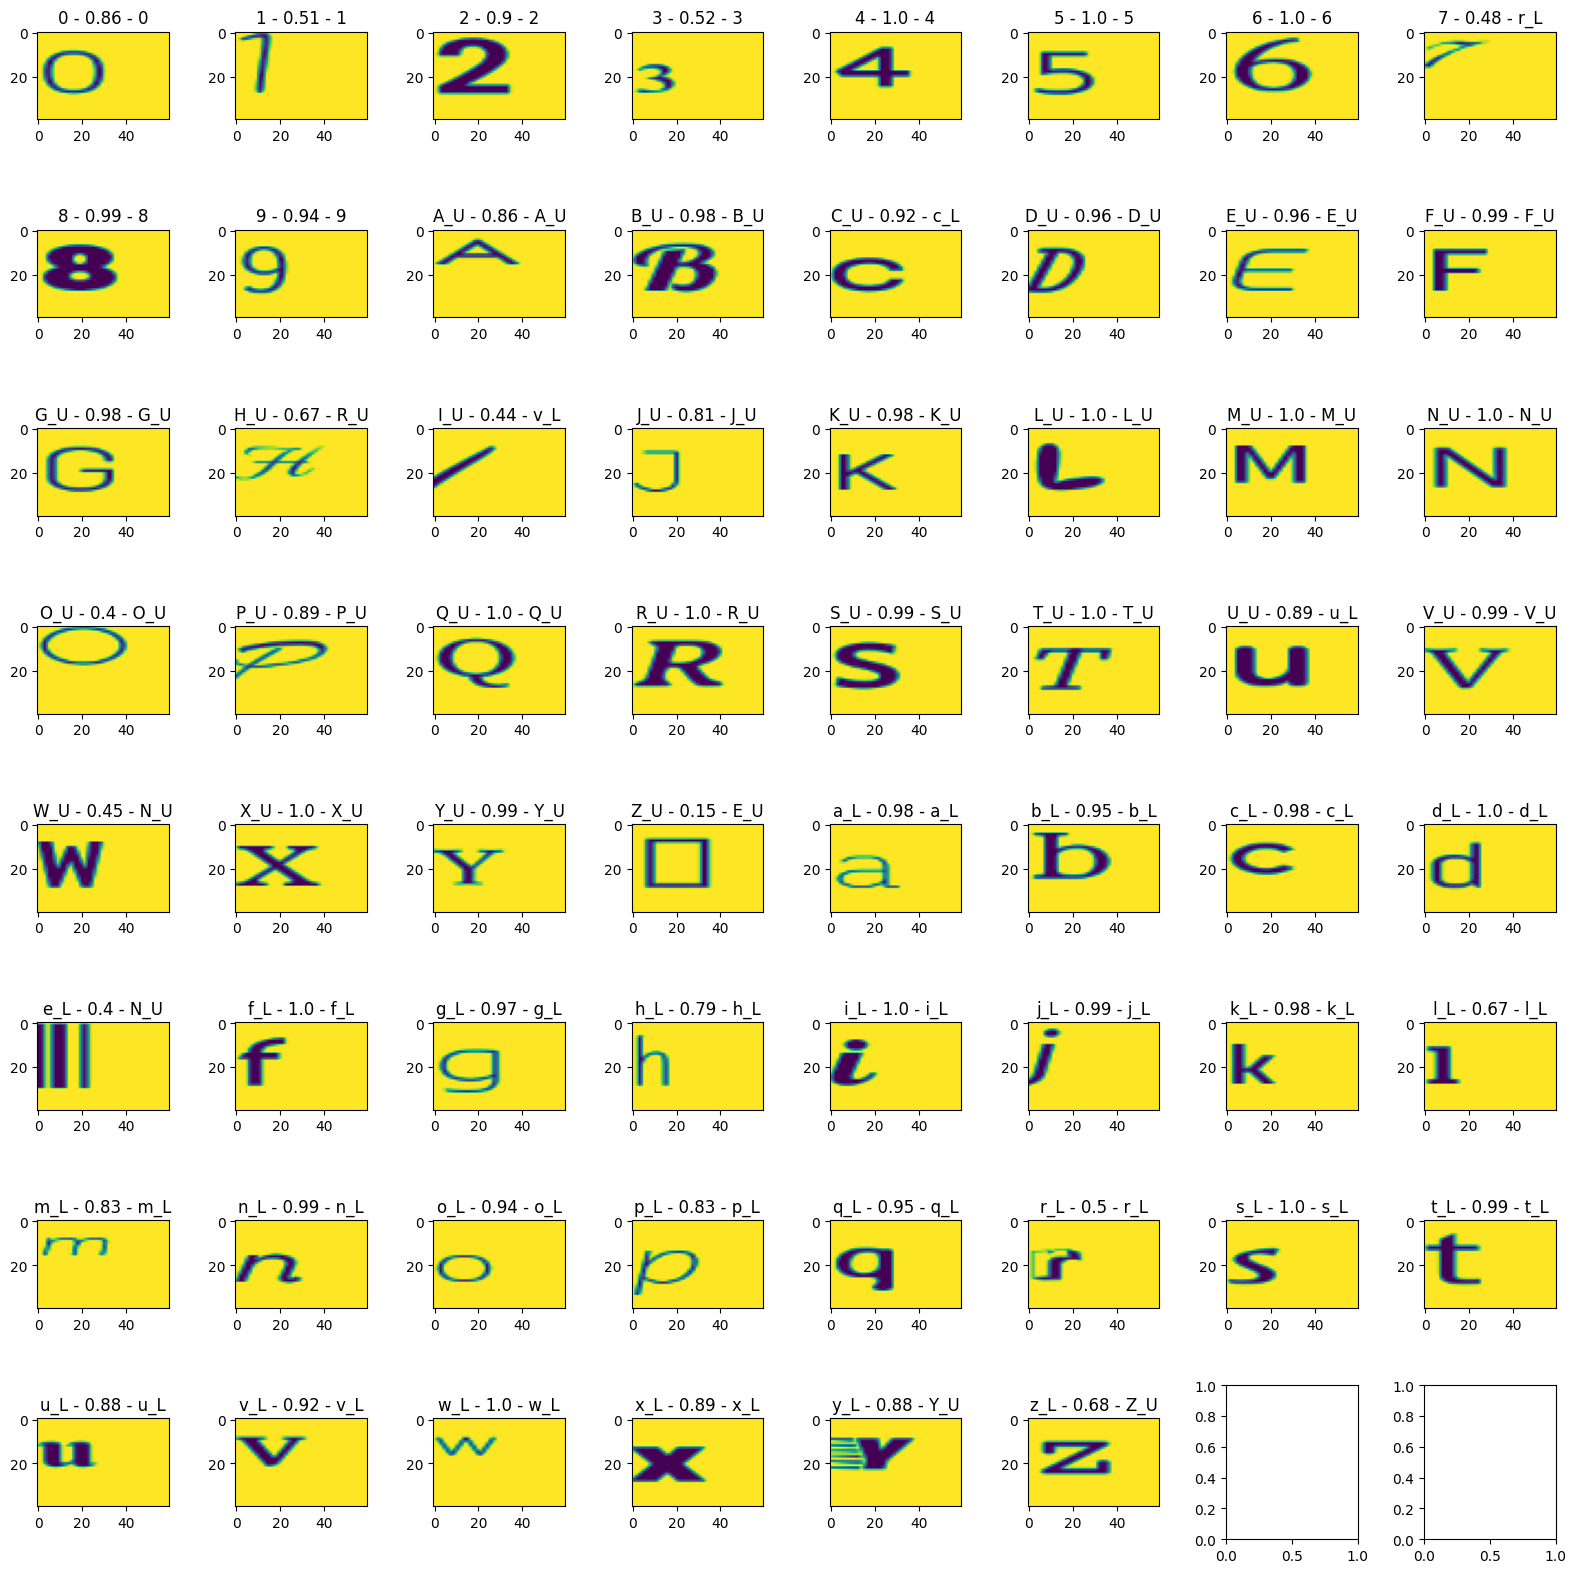

In [206]:
acc_pred = [f"{round(float(yhat[i][np.argmax(yhat[i])]),2)} - {class_names[np.argmax(yhat[i])]}" for i in range(len(yhat))]
print(acc_pred)
plot_those_imgs(resize,acc=acc_pred)